In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT

from my_utils import *

def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(  np.dot(deviations**2,weights)   )
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(  sum(deviations**2) /len(x)  )
def list_mean(x):
  mean = sum(x)/len(x)
  return mean



Welcome to JupyROOT 6.14/04


In [2]:
#db.board_list()
import tdc_daq as td
import matplotlib.pyplot as plt
import time
import db

#set all boards to standby
for my_board in db.board_list():
      db.set_standby_board(my_board)
      ptc.set_threshold_for_board_by_name(my_board,127)
      db.disable_board(my_board)


[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


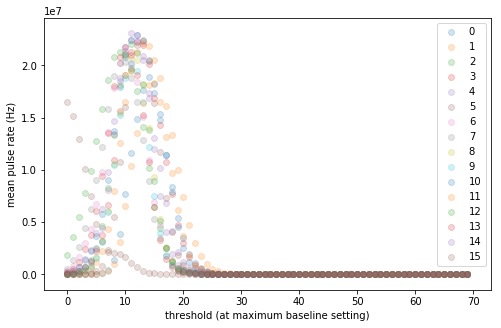

0108 average(16chan) noise thresh: mean =  11.148  +-  2.637   |  RMS  =  3.292  +-  0.396
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]


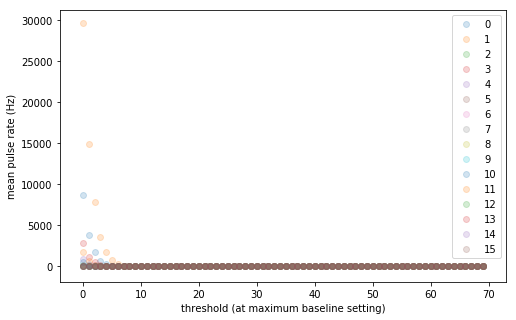

0108 average(16chan) noise thresh: mean =  11.176  +-  9.323   |  RMS  =  13.219  +-  7.198
channel :  0


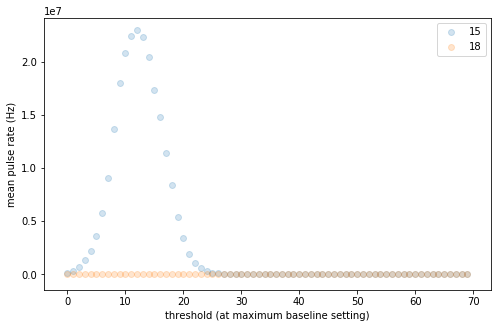

channel :  1


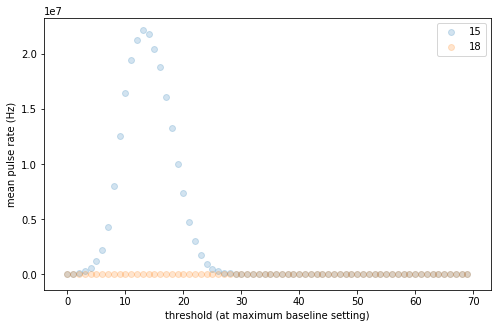

channel :  2


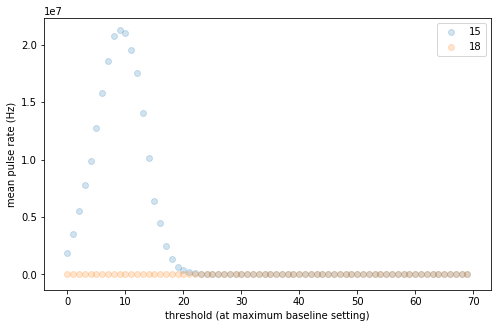

channel :  3


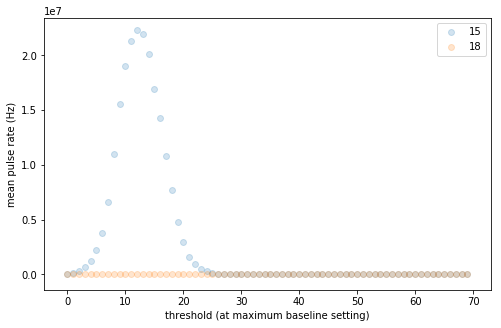

channel :  4


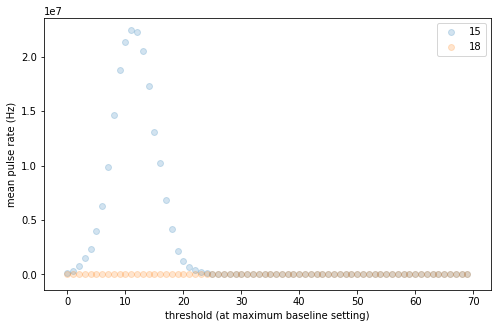

channel :  5


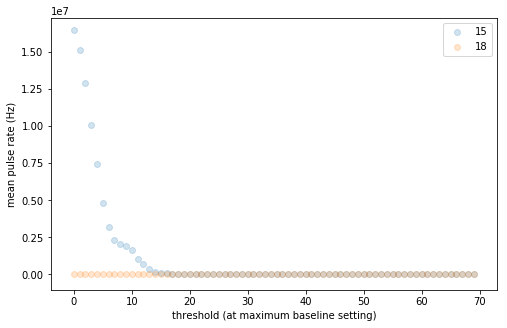

channel :  6


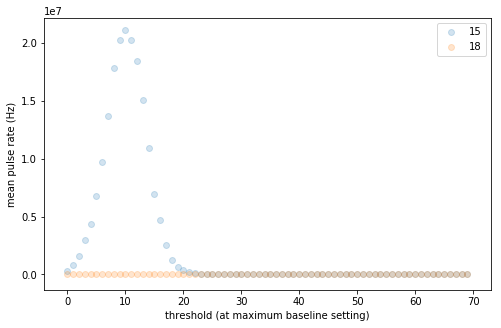

channel :  7


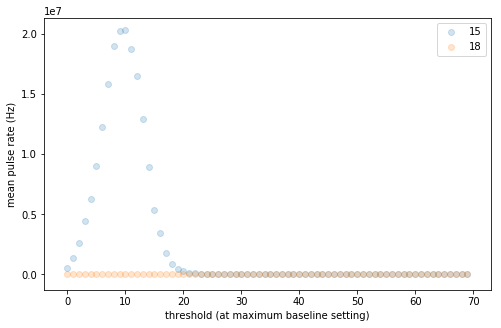

channel :  8


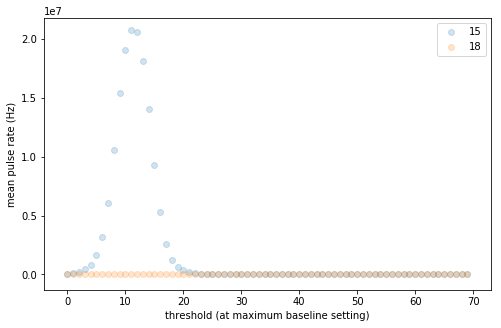

channel :  9


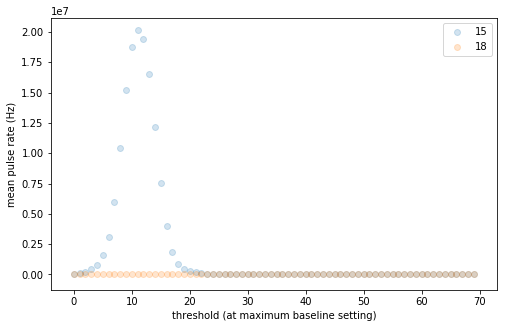

channel :  10


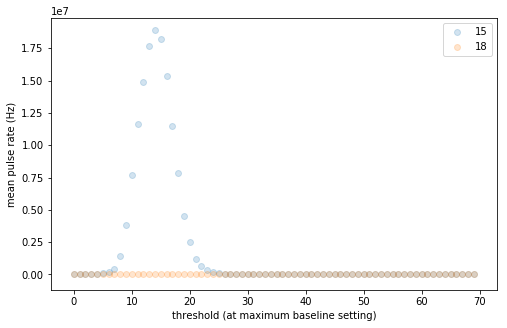

channel :  11


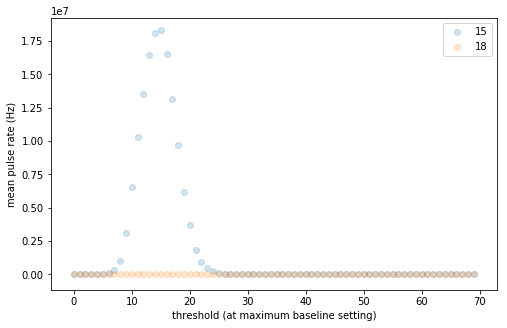

channel :  12


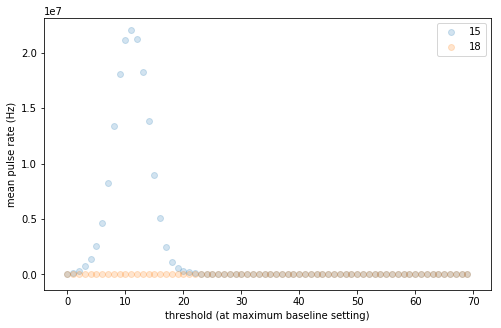

channel :  13


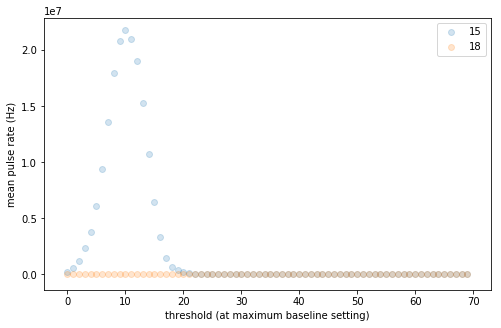

channel :  14


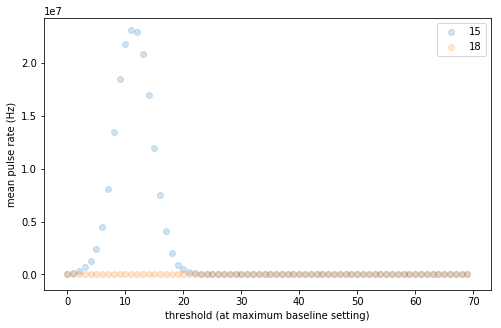

channel :  15


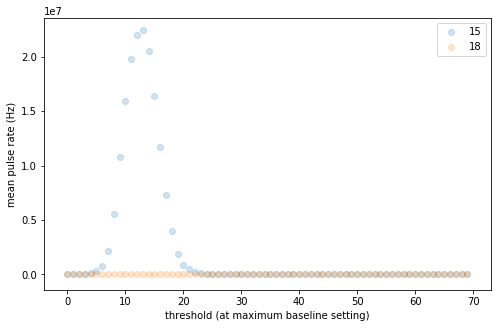

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached


In [3]:
## scan threshold of all boar
from functools import (reduce)
from math import (sqrt)
import numpy as np
import time
import tdc_daq as td
import matplotlib.pyplot as plt

# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)



#for my_board in db.board_list():
#  db.unset_standby_board(my_board) #name = "0029" #PASSTEC board id (inside )

#used_boards = [ "0005", "0017", "0014", "0025" ]
#used_boards = [ "0101", "0102", "0103", "0010" , "0009", "0004", "0025"]
used_boards = ["0108"]
# used_boards = ["0101", "0010"]
#, "0010", "0102", "0103"]
channel_to_adjust_baseline = 0
default_baseline_for_other_channels = 15 
n_baselines_steps = 2
baseline_step_add = 3

plt.rcParams["figure.figsize"] = (8,5)
trendtime_list = []
rmsAverageTrend_list = []
rmsAverageTrendError_list = []
meanAverageTrend_list = []
meanAverageTrendError_list = []

scaler_list_channel = [[[] for i in range(n_baselines_steps) ]  for i in range(16)] 

baseline = [0] * n_baselines_steps

for baseline_step in range(0,n_baselines_steps):
 #baselines_set =  [-10] * 16 
 baselines_set =  [default_baseline_for_other_channels] * 16 
   
 for name in used_boards: 
    #if name == "0013" or name == "0018":
    #  continue
    for my_board in db.board_list():
      db.set_standby_board(my_board)
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
   
    #time.sleep(60)
    trendtime_list += [ name ]
    baseline[baseline_step] = default_baseline_for_other_channels+(baseline_step*baseline_step_add)
    baselines_set[channel_to_adjust_baseline] = baseline[baseline_step]
    baselines_set = [ baseline[baseline_step] ] * 16
    print (baselines_set)
    baseline_calib.set_baselines_individual(name,baselines_set)
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)
    calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]

    scaler_list = []
    scaler_list = td.scaler_rate_of_board(name,0.2)
    

    for i in range(0,16):
     plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()

    fwhm_list = []
    max_list  = []
    rms_list = []
    mean_list = []
    for i in range(0,16):
      fwhm_list += [ fwhm(tsbl_range,tsbl_scan_raw[i]) ]
      rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
      mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  
      max_list  += [ np.max(tsbl_scan_raw[i])  ]
      scaler_list_channel[i][baseline_step] = tsbl_scan_raw[i] 

    fwhm_list = np.array(fwhm_list)
    max_list  = np.array(max_list)
    
    print(name, "average(16chan) noise thresh: mean = ", round(sum(mean_list)/len(mean_list),3), " +- ", round(list_rms(mean_list),3), "  |  RMS  = ", round(sum(rms_list)/len(rms_list),3), " +- ", round(list_rms(rms_list),3) )

    meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
    meanAverageTrendError_list += [ list_rms(mean_list) ]
    rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
    rmsAverageTrendError_list += [ list_rms(rms_list) ]    
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     plt.scatter(tsbl_range,scaler_list_channel[ch][i],alpha=0.2,label = "{:d}".format(baseline[i]))

     plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()
#     plt.scatter(list(range(0,16)), mean_list)
#     plt.xlabel("channel no")
#     plt.ylabel("mean")
#     plt.show()
#     plt.scatter(list(range(0,16)), rms_list)
#     plt.xlabel("channel no")
#     plt.ylabel("RMS")
#     plt.title("noise width (RMS)")
#     plt.show()


channel :  0
channel :  1
channel :  2
channel :  3
channel :  4
channel :  5
channel :  6
channel :  7
channel :  8
channel :  9
channel :  10
channel :  11
channel :  12
channel :  13
channel :  14
channel :  15


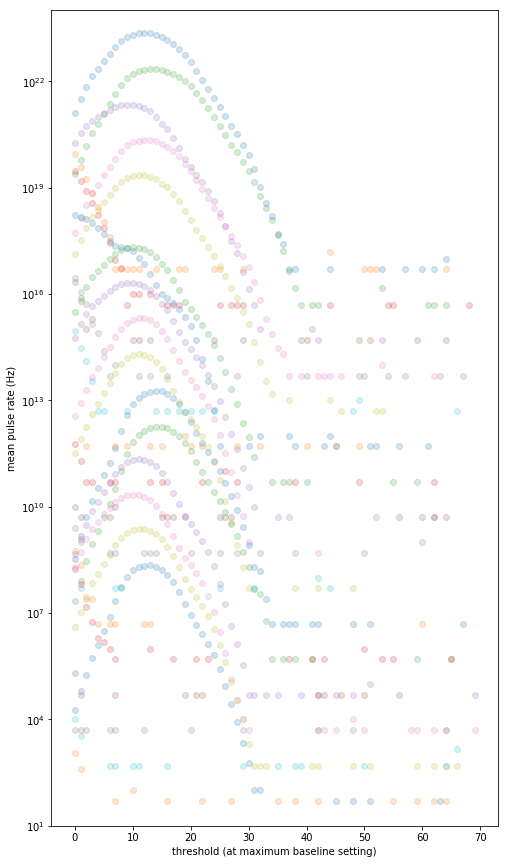

In [4]:
plt.rcParams["figure.figsize"] = (8,15)
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     nums = np.array(scaler_list_channel[ch][i])*10**(16-ch)
     plt.scatter(tsbl_range,nums,alpha=0.2,label = "{:d}".format(baseline[i]))

     #plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")

plt.yscale('log') 
plt.ylim(ymax = 1E24, ymin = 1E1)
plt.show()